# Colour Correction using Splines

### Define constants

In [56]:
%load_ext autoreload
%autoreload 2
import colour
from data import load_dataset_sfu, load_dataset_csv, load_msds_canon, load_msds_sigma, load_msds_nikon, load_illuminant_cmfs, load_camera
import numpy as np

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

SFU_FILE_PATH = 'reflect_db.reflect'
CAVE_FOSTER2004_PATH = 'cave_foster2004.csv'
FOSTER_50_PATH = 'foster50.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
sfu_dataset = load_dataset_sfu(SFU_FILE_PATH)
cave_foster2004_dataset = load_dataset_csv(CAVE_FOSTER2004_PATH)
foster_50_dataset = load_dataset_csv(FOSTER_50_PATH)

TRAIN = cave_foster2004_dataset
TEST = foster_50_dataset
VALIDATION = sfu_dataset
CAMERA = 'nikon'

### Spectral sensitivities of various cameras

In [58]:

MSDS_TRAIN, SDS_TRAIN = load_camera(CAMERA)
print(foster_50_dataset.values.shape)

(31, 204800)


### Computing Observer Responses
We can easily change the order of test and train sets here

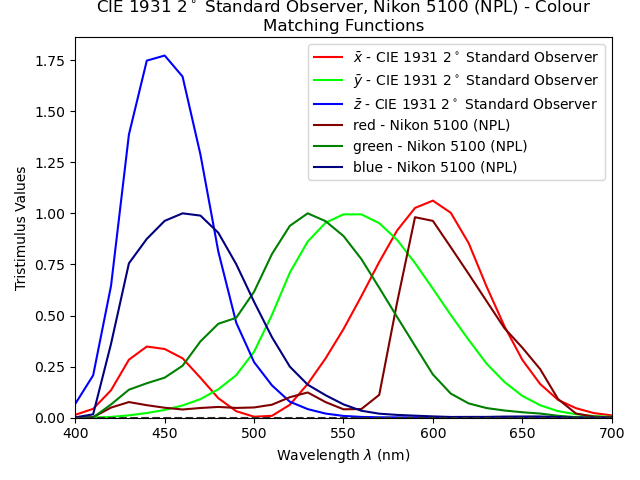

In [59]:
illuminant, cmfs = load_illuminant_cmfs()
colour.plotting.plot_multi_cmfs([MSDS_TRAIN, cmfs])
response_trainset_xyz = colour.characterisation.training_data_sds_to_XYZ(TRAIN, cmfs, illuminant)
response_testset_xyz = colour.characterisation.training_data_sds_to_XYZ(TEST, cmfs, illuminant)
response_validation_xyz = colour.characterisation.training_data_sds_to_XYZ(VALIDATION, cmfs, illuminant)

### Chromaticity Diagrams

C:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
C:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


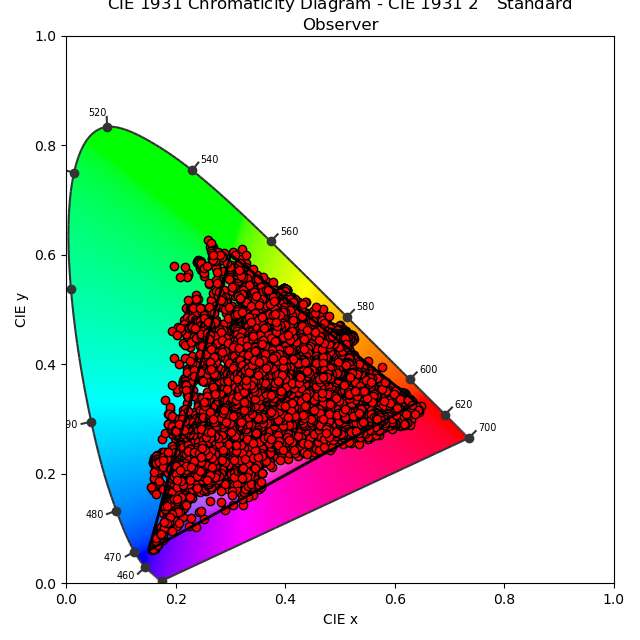

C:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
C:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


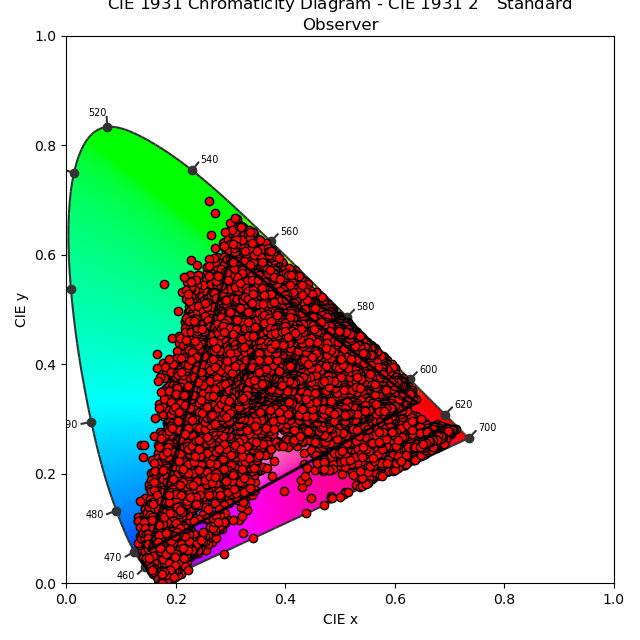

C:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
C:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


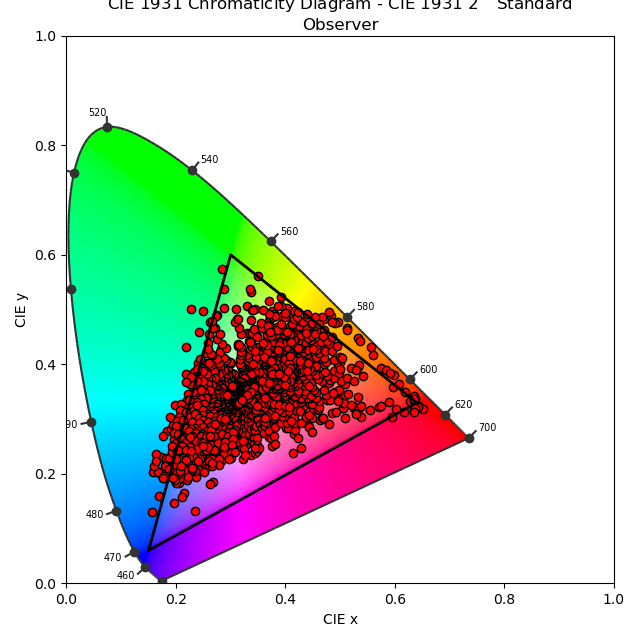

In [60]:
from plotting import plot_chromaticity_diagram
plot_chromaticity_diagram(response_trainset_xyz)
plot_chromaticity_diagram(response_testset_xyz)
plot_chromaticity_diagram(response_validation_xyz)

### Computing Nikon Responses

In [61]:
response_trainset_nikon, _ = colour.characterisation.training_data_sds_to_RGB(TRAIN, MSDS_TRAIN, SDS_TRAIN)
response_testset_nikon, _ = colour.characterisation.training_data_sds_to_RGB(TEST, MSDS_TRAIN, SDS_TRAIN)

### Fit Generalized Additive Model with P-splines

In [62]:
from models import GAMOptimizer
from evaluate import pred
gam = GAMOptimizer(lams=0.1, order=3, n_splines=20)
gam.fit(response_trainset_nikon, response_trainset_xyz)
pred(gam, response_testset_nikon, response_testset_xyz, "DeltaE Foster+CAVE")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.8199201286337032
DeltaE max: 4.706776953212044
DeltaE min: 0.004766125925968777
DeltaE median: 0.6939885966291368
DeltaE 95 percentile: 1.892751438120057
DeltaE 99 percentile: 2.352832848101305


### Fit Linear Model

In [63]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression()


linear.fit(response_trainset_nikon, response_trainset_xyz)
pred(linear, response_testset_nikon, response_testset_xyz, "DeltaE Foster+CAVE")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.0250864002520783
DeltaE max: 4.6122585687010735
DeltaE min: 0.011695430123752843
DeltaE median: 0.9467562053669141
DeltaE 95 percentile: 2.025391139022792
DeltaE 99 percentile: 2.6333663561879517


### Fit 3rd order Root-Polynomial Model

In [64]:
from models import GAMOptimizer, PolynomialTransformer, DeltaEOptimizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

RP_linear = Pipeline([
    ('transformer', PolynomialTransformer(degree=3, rp=True)),
    ('regressor', LinearRegression())
])


RP_linear.fit(response_trainset_nikon, response_trainset_xyz)
pred(RP_linear, response_testset_nikon, response_testset_xyz, "DeltaE Foster+CAVE")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.9590272161515646
DeltaE max: 4.486961888944559
DeltaE min: 0.006719198978417442
DeltaE median: 0.7840414490837465
DeltaE 95 percentile: 2.209955416048026
DeltaE 99 percentile: 2.6120565676710195


### Fit a 2nd order Root-Polynomial Model

In [65]:
from models import GAMOptimizer, PolynomialTransformer, DeltaEOptimizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

RP_linear = Pipeline([
    ('transformer', PolynomialTransformer(degree=2, rp=True)),
    ('regressor', LinearRegression())
])


RP_linear.fit(response_trainset_nikon, response_trainset_xyz)
pred(RP_linear, response_testset_nikon, response_testset_xyz, "DeltaE Foster+CAVE")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.995300589095684
DeltaE max: 4.487781683702563
DeltaE min: 0.003081138519581314
DeltaE median: 0.8158621767624825
DeltaE 95 percentile: 2.262532282102107
DeltaE 99 percentile: 2.7390128583887363


In [66]:
P_linear = Pipeline([
    ('transformer', PolynomialTransformer(degree=3, rp=False)),
    ('regressor', LinearRegression())
])


P_linear.fit(response_trainset_nikon, response_trainset_xyz)
pred(P_linear, response_testset_nikon, response_testset_xyz, "DeltaE Foster+CAVE")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.0325026670998811
DeltaE max: 4.49980370341261
DeltaE min: 0.007377759714506424
DeltaE median: 0.9003266250689512
DeltaE 95 percentile: 2.184066190461398
DeltaE 99 percentile: 2.5727065287057873


In [67]:
P_linear = Pipeline([
    ('transformer', PolynomialTransformer(degree=2, rp=False)),
    ('regressor', LinearRegression())
])


P_linear.fit(response_trainset_nikon, response_trainset_xyz)
pred(P_linear, response_testset_nikon, response_testset_xyz, "DeltaE Foster+CAVE")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.0631721530622844
DeltaE max: 4.612342335157946
DeltaE min: 0.009737411746410308
DeltaE median: 0.9503874561120322
DeltaE 95 percentile: 2.1918746513631198
DeltaE 99 percentile: 2.612585922229696


In [68]:
%%script false --no-raise-error

DE2000RP = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=False, degree=3))
])


DE2000RP.fit(response_trainset_nikon, response_trainset_xyz)
pred(DE2000RP, response_testset_nikon, response_testset_xyz, "DeltaE Foster+CAVE")

Couldn't find program: 'false'


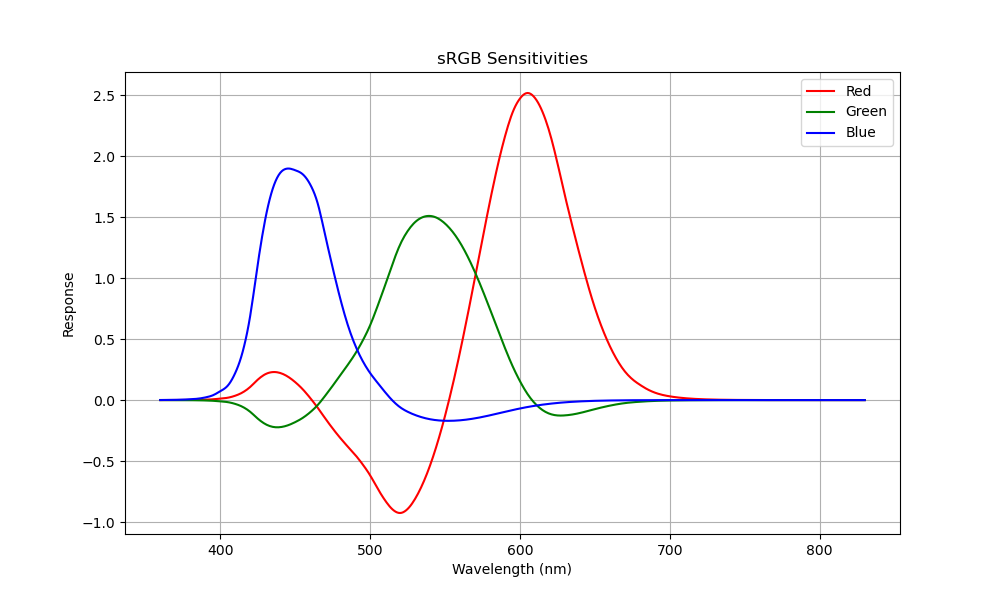

In [69]:
import colour
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the XYZ colour matching functions.
cmfs = colour.colorimetry.MSDS_CMFS['CIE 1931 2 Degree Standard Observer']

# Wavelengths of the standard observer.
wavelengths = cmfs.wavelengths

# Converting XYZ to sRGB sensitivities
# sRGB colour matching functions are derived from the XYZ ones by applying the sRGB colour space matrix.
rgb_colourspace = colour.RGB_COLOURSPACES['sRGB']
matrix_XYZ_to_RGB = rgb_colourspace.matrix_XYZ_to_RGB

# Applying the matrix to each XYZ sensitivity
sRGB_sensitivities = np.dot(cmfs.values, matrix_XYZ_to_RGB.T)

# Plotting the sensitivities
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, sRGB_sensitivities[:, 0], label='Red', color='r')
plt.plot(wavelengths, sRGB_sensitivities[:, 1], label='Green', color='g')
plt.plot(wavelengths, sRGB_sensitivities[:, 2], label='Blue', color='b')
plt.title('sRGB Sensitivities')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.legend()
plt.grid(True)


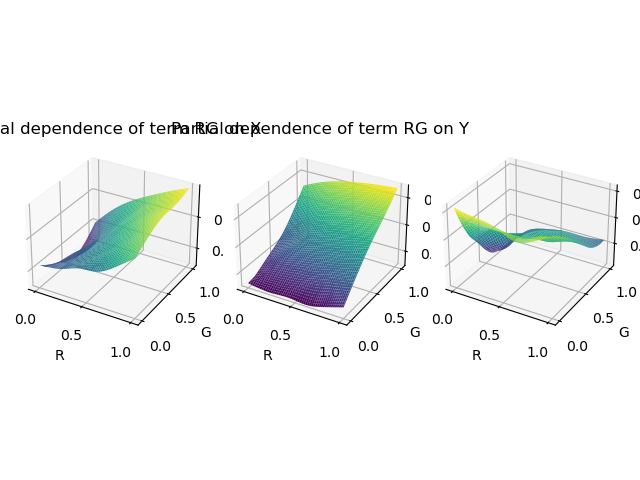

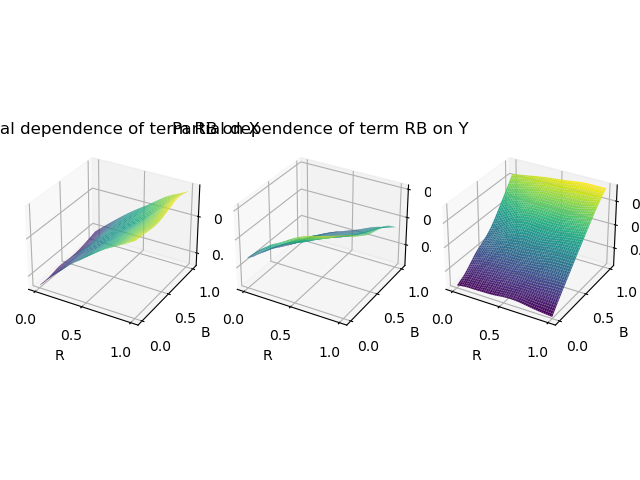

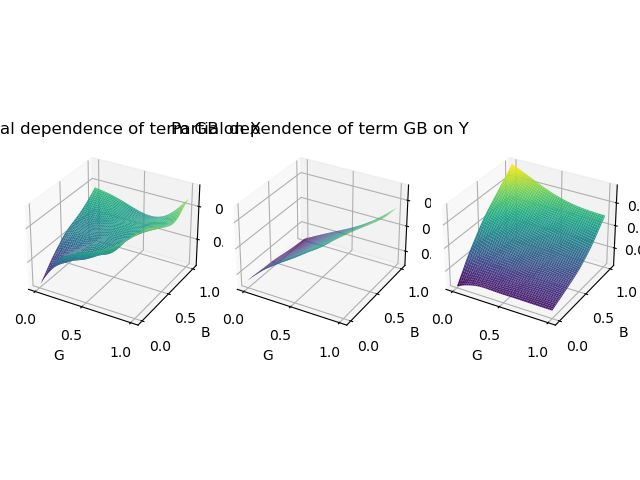

In [70]:
%matplotlib ipympl

gam.plot_partial_dependences()